Here we open the json data and normalize the data such that each row corresponds to one ingredient.

The dataset has already been parsed by a CRF model to turn the freeform recipe ingredients into structured data (name, unit, quantity).

In [2]:
import pandas as pd
import json

with open('enriched_recipes.json') as f:
    data = json.load(f)
    df = pd.json_normalize(
        data, 'parsed_ingredients',
        meta=['author',
              'photo_url',
              'prep_time_minutes',
              'rating_stars',
              'review_count',
              'title',
              'total_time_minutes',
              'url'
             ],
        record_prefix='ingredient_', errors='ignore')

The output data looks like this:

Filter the data where recipe ratings are valid (more than 20 reviews and more than 0 stars).

Then, group the ingredients by ingredient name, and average each ingredient's numerical rating.

In [3]:
rating_by_ingredient = df.where(
    df['rating_stars'] > 0
).where(
    df['review_count'] > 20
).groupby(
    "ingredient_name"
).agg(
    avg_rating=("rating_stars", "mean")
).reset_index()

rating_by_ingredient.sort_values(by="avg_rating")

,ingredient_name,avg_rating
491,(10 ounce) package frozen mixed stir-fry veget...,2.41
1729,(8 ounce) jar dried chipped beef,2.71
6002,fluid ounces orange-flavored carbonated beverage,2.76
7319,"package moist cake mix, any flavor",2.77
5302,cocoa mix,2.89
...,...,...
9134,white truffle oil,4.97
9166,whole garlic,4.97
8387,sour mash whiskey,4.97
1061,(16.5 ounce) package refrigerated sliceable su...,4.97


In [4]:
pd.set_option('display.max_rows', 1000)

df["ingredient_name"] = df["ingredient_name"].str.lower()

df["ingredient_name"].value_counts().head(1000)


salt                                                             33821
butter                                                           24428
water                                                            19731
all-purpose flour                                                18193
garlic                                                           18066
onion                                                            16757
white sugar                                                      16544
eggs                                                             14806
olive oil                                                        13856
milk                                                             12072
vanilla extract                                                  11438
black pepper                                                     11092
egg                                                              10895
sugar                                                             9583
brown 

In [5]:
name_cleaning_map = {
    "egg": "eggs",
    "tomato": "tomatoes",
    "all-purpose flour": "flour",
    "sugar": "white sugar",
    "salt and black pepper": "salt and pepper",
    "carrot": "carrots",
    "basil leaves": "basil",
    "mozzarella cheese": "mozzarella",
    "parmesan cheese": "parmesan",
    "feta cheese": "feta",
    "confectioners' sugar": "powdered sugar",
    "oil": "vegetable oil",
    "heavy whipping cream": "heavy cream",
    "green onion": "green onions",
    "chicken breast": "chicken breasts",
    "pepper": "black pepper",
}

df["ingredient_name"] = df["ingredient_name"].apply(
    lambda name: name_cleaning_map.get(name, name))

df["ingredient_name"].value_counts().head(1000)

salt                                                             33821
white sugar                                                      26127
eggs                                                             25701
butter                                                           24428
water                                                            19731
flour                                                            19531
garlic                                                           18066
onion                                                            16757
black pepper                                                     15574
olive oil                                                        13856
milk                                                             12072
vanilla extract                                                  11438
vegetable oil                                                    10167
salt and pepper                                                   9983
brown 

In [6]:
spices = [
    'allspice',
    'angelica',
    'anise',
    'asafoetida',
    'bay leaf',
    'basil',
    'bergamot',
    'black cumin',
    'black mustard',
    'black pepper',
    'borage',
    'brown mustard',
    'burnet',
    'caraway',
    'cardamom',
    'cassia',
    'catnip',
    'cayenne pepper',
    'celery seed',
    'chervil',
    'chicory',
    'chili pepper',
    'chives',
    'cicely',
    'cilantro',
    'cinnamon',
    'clove',
    'coriander',
    'costmary',
    'cumin',
    'curry',
    'dill',
    'fennel',
    'fenugreek',
    'filé',
    'garlic powder',
    'ginger',
    'grains of paradise',
    'holy basil',
    'horehound',
    'horseradish',
    'hyssop',
    'lavender',
    'lemon balm',
    'lemon grass',
    'lemon verbena',
    'licorice',
    'lovage',
    'mace',
    'marjoram',
    'nutmeg',
    'oregano',
    'onion powder',
    'paprika',
    'parsley',
    'peppermint',
    'poppy seed',
    'rosemary',
    'rue',
    'saffron',
    'sage',
    'savory',
    'sesame',
    'sorrel',
    'star anise',
    'spearmint',
    'tarragon',
    'thyme',
    'tumeric',
    'vanilla',
    'wasabi',
    'white mustard'
]

In [7]:
spices_regex = r"|".join(spices)
df['ingredient_name'].value_counts()[:110]

salt                    33821
white sugar             26127
eggs                    25701
butter                  24428
water                   19731
flour                   19531
garlic                  18066
onion                   16757
black pepper            15574
olive oil               13856
milk                    12072
vanilla extract         11438
vegetable oil           10167
salt and pepper          9983
brown sugar              9317
cinnamon                 8517
tomatoes                 7434
lemon juice              7079
baking powder            6629
baking soda              6070
parsley                  5318
parmesan                 5209
cheddar cheese           5009
carrots                  5002
green onions             4797
sour cream               4603
basil                    4472
celery                   4446
chicken breasts          4441
garlic powder            4289
chicken broth            4199
powdered sugar           4115
cream cheese             3963
beef      

In [8]:
recipes_with_spices = df.loc[df['ingredient_name'].str.contains(spices_regex).fillna(False)]

replace_dict = {}

for spice in spices:
    replace_dict[f".*{spice}.*"] = spice

recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)

/tmp/ipykernel_9384/1310573300.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)


In [9]:
common_spices = set(recipes_with_spices['spice'].value_counts().head(20).index)
recipes_with_spices['spice'].value_counts()

black pepper      16999
vanilla           14990
cinnamon           9323
parsley            6578
ginger             5402
basil              5045
garlic powder      4395
cilantro           4126
nutmeg             3784
cumin              3696
sage               3633
oregano            3618
thyme              3491
cayenne pepper     3126
paprika            3059
clove              2382
sesame             2363
dill               1930
rosemary           1912
curry              1502
onion powder       1378
allspice           1142
chives             1043
bay leaf            995
coriander           882
tarragon            696
fennel              576
horseradish         574
cardamom            556
celery seed         430
marjoram            425
poppy seed          387
peppermint          344
anise               316
caraway             282
brown mustard       220
saffron             217
savory              183
mace                131
wasabi              112
lemon grass          88
chili pepper    

In [10]:
spices_count = recipes_with_spices.groupby(
    "url", as_index=False
).agg(
    spices_count=("spice", "count"), url=("url", "first")
)

spices_count
recipes_with_spices
recipes_with_spices_with_count = recipes_with_spices.merge(
    spices_count, on="url"
)

multi_spice_recipes = recipes_with_spices_with_count.loc[
    recipes_with_spices_with_count["spices_count"] > 1
]

common_multi_spice_recipes = multi_spice_recipes[multi_spice_recipes['spice'].isin(common_spices)]

dummy = pd.get_dummies(
    common_multi_spice_recipes,
    columns=["spice"],
    prefix='',
    prefix_sep=''
).groupby(['url'], as_index=False).max()

/tmp/ipykernel_9384/3161357080.py:24: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ).groupby(['url'], as_index=False).max()


In [11]:
spice_corr = dummy.drop(columns=multi_spice_recipes.columns, errors="ignore")
corr = spice_corr.corr()

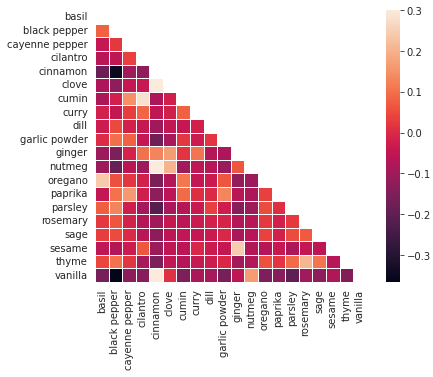

In [12]:
# plot spices correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 15]

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(7, 5))
    ax.tick_params(axis='x', labelrotation=45)

    sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)


In [13]:
# normalize ingredient quantity

def convert_to_float(frac_str):
    frac_str = frac_str.strip()

    if " " in frac_str and "/" not in frac_str:
        return None
    try:
        return float(frac_str)
    except ValueError:
        if "/" not in frac_str:
            return None
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        try:
            frac = float(num) / float(denom)
            return whole - frac if whole < 0 else whole + frac
        except Exception as e:
            return None

has_qty = df[df['ingredient_qty'].notnull()]

has_qty["quantity_float"] = has_qty["ingredient_qty"].apply(convert_to_float)

has_qty_float = has_qty.loc[has_qty["quantity_float"].notnull()]

has_qty_float
has_qty.loc[has_qty["ingredient_unit"] =="tablespoon"]["ingredient_name"].value_counts()[:50]

/tmp/ipykernel_9384/80687927.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_qty["quantity_float"] = has_qty["ingredient_qty"].apply(convert_to_float)


butter                    10418
olive oil                  9230
vegetable oil              4649
white sugar                4572
lemon juice                3844
flour                      3477
water                      2747
parsley                    2583
brown sugar                1968
soy sauce                  1966
cornstarch                 1866
honey                      1667
milk                       1586
garlic                     1424
lime juice                 1392
unsalted butter            1293
salt                       1271
cilantro                   1246
parmesan                   1215
worcestershire sauce       1200
basil                      1089
onion                      1065
dijon mustard               874
chili powder                871
vanilla extract             854
canola oil                  846
baking powder               790
mayonnaise                  778
balsamic vinegar            747
ginger                      723
margarine                   696
cinnamon

In [14]:
NUM_INGREDIENTS_FOR_GRAPH = 100

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(NUM_INGREDIENTS_FOR_GRAPH, columns=["ingredient_count"])

ingredient_count.reset_index(inplace=True)

common_ingredients = set(ingredient_count["ingredient_name"])

common_subset = df.loc[df["ingredient_name"].isin(common_ingredients)]

sr_28 = pd.read_csv("ABBREV.csv")

sr28_descriptions = {
    "unsalted butter": "BUTTER,WITHOUT SALT",
    "flour": "WHEAT FLOURS,BREAD,UNENR",
    "salt": "SALT,TABLE",
    "white sugar": "SUGARS,GRANULATED",
    "baking powder": "LEAVENING AGENTS,BAKING PDR,DOUBLE-ACTING,STRAIGHT PO4",
    "baking soda": "LEAVENING AGENTS,BAKING SODA",
    "buttermilk": "MILK,BTTRMLK,FLUID,WHL",
    "eggs": "EGG,WHL,RAW,FRSH",
    "basil": "SPICES,BASIL,DRIED",
    "parmesan": "CHEESE,PARMESAN,GRATED",
    # lol
    "water": "WATER,BTLD,GENERIC",
    "margarine": "MARGARINE,REG,80% FAT,COMP,STK,W/ SALT",
    "vegetable oil": "USDA CMDTY FD,OIL,VEG,SOYBN,REFINED",
    "butter": "BUTTER,WITH SALT",
    "milk": "MILK,RED FAT,FLUID,2% MILKFAT,WO/ ADDED VIT A & VIT D",
    "sour cream": "SOUR CREAM,LIGHT",
    "shortening": "SHORTENING,HOUSEHOLD,LARD&VEG OIL",
    "walnuts": "WALNUTS,ENGLISH",
    "raisins": "RAISINS,SEEDLESS",
    "green onions": "ONIONS,SPRING OR SCALLIONS (INCL TOPS&BULB),RAW",
    "olive oil": "OIL,OLIVE,SALAD OR COOKING",
    "cocoa powder": "COCOA,DRY PDR,UNSWTND",
    "onion": "ONIONS,RAW",
    # garlic salt is mostly salt, with some garlic
    "garlic salt": "SALT,TABLE",
    "zucchini": "SQUASH,SMMR,ZUCCHINI,INCL SKN,RAW",
    "mozzarella": "CHEESE,MOZZARELLA,WHL MILK",
    "brown sugar": "SUGARS,BROWN",
    "powdered sugar": "SUGARS,POWDERED",
    "lemon": "LEMON JUICE,RAW",
    "oregano": "SPICES,OREGANO,DRIED",
    "chocolate chips": "CANDIES,SEMISWEET CHOC",
    "coconut": "COCONUT MEAT,DRIED (DESICCATED),NOT SWTND",
    "mayonnaise": "MAYONNAISE,RED FAT,W/ OLIVE OIL",
    "thyme": "SPICES,THYME,DRIED",
    "red pepper flakes": "PEPPER,RED OR CAYENNE",
    "cayenne pepper": "PEPPER,RED OR CAYENNE",
    "apples": "APPLES,RAW,WITH SKIN",
    "peanut butter": "PEANUT BUTTER,SMOOTH STYLE,W/ SALT",
    "potatoes": "POTATOES,RAW,SKIN",
    "heavy cream": "CREAM,FLUID,HVY WHIPPING",
    "green bell pepper": "PEPPERS,SWT,GRN,RAW",
    "red bell pepper": "PEPPERS,SWT,RED,RAW",
    "shrimp": "CRUSTACEANS,SHRIMP,MXD SP,RAW (MAYBE PREVIOUSLY FROZEN)",
    "cumin": "CUMIN SEED",
    "mushrooms": "MUSHROOMS,WHITE,RAW",
    "lime": "LIMES,RAW",
    "soy sauce": "SOY SAU MADE FROM HYDROLYZED VEG PROT",
    "chicken broth": "SOUP,CHICK BROTH,RTS",
    "white vinegar": "VINEGAR,DISTILLED",
    "tomato paste": "TOMATO PRODUCTS,CND,PASTE,WO/ SALT ADDED",
    "tomato sauce": "TOMATO PRODUCTS,CND,SAU",

    # close enough?
    "almond extract": "VANILLA EXTRACT",
    "chicken breasts": "CHICKEN,BROILERS OR FRYERS,MEAT & SKN,RAW",
    "bread crumbs": "BREAD CRUMBS,DRY,GRATED,PLN",
    "chicken": "CHICKEN,BROILERS OR FRYERS,MEAT & SKN,RAW",
    "ham": "HAM,CHOPPED,NOT CANNED",
    "tomatoes": "TOMATOES,RED,RIPE,RAW,YEAR RND AVERAGE",
    "bacon": "PORK,CURED,BACON,CKD,BRLD,PAN-FRIED OR RSTD,RED NA",
    "mustard": "MUSTARD,PREPARED,YELLOW",
    "beef": "BEEF,GRASS-FED,STRIP STEAKS,LN,RAW",
    "cilantro": "CORIANDER (CILANTRO) LEAVES,RAW",
    "red onion": "ONIONS,RAW",
    "ketchup": "Catsup",
    "dijon mustard": "MUSTARD,PREPARED,YELLOW",
    "cooking spray": "OIL,PAM COOKING SPRAY,ORIGINAL",
    "hot pepper sauce": "SAUCE,RTS,PEPPER OR HOT",
    "salt and pepper": "SALT,TABLE",
}

unique_ingredients = common_subset["ingredient_name"].unique()

def find_sr_28_description(ingredient):
    if ingredient in sr28_descriptions:
        return sr28_descriptions[ingredient]

    split_ingredient = ingredient.upper().split(" ", 2)
    if len(split_ingredient) > 1:
        reformatted = split_ingredient[1] + "," + split_ingredient[0]
    else:
        reformatted = ingredient.upper()

    has_ingredient = (sr_28.loc[
        (sr_28["Shrt_Desc"] == sr28_descriptions.get(ingredient)) | 
        (sr_28["Shrt_Desc"] == reformatted) |
        (sr_28["Shrt_Desc"] == ingredient.upper()) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",RAW")) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",DRIED")) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",GROUND"))
    ])

    # cache the ingredient
    sr28_descriptions[ingredient] = has_ingredient["Shrt_Desc"].head().item()

    return has_ingredient["Shrt_Desc"].head().item()

common_subset["Shrt_Desc"] = common_subset["ingredient_name"].apply(
    find_sr_28_description)

common_sr28 = sr_28[sr_28["Shrt_Desc"].isin(
    common_subset["Shrt_Desc"].unique()
)]

/tmp/ipykernel_9384/2124828951.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_subset["Shrt_Desc"] = common_subset["ingredient_name"].apply(


In [15]:
from pint import UnitRegistry
import pint_pandas

ureg = UnitRegistry()

def find_density(row):
    gram1 = row["GmWt_1"]
    gram2 = row["GmWt_2"]
            
    vol1 = row["GmWt_Desc1"]
    vol2 = row["GmWt_Desc2"]

    density_input_attempts = [
        (gram1, vol1),
    ]

    if vol2:
        density_input_attempts.append((gram2, vol2))

    if vol1 and type(vol1) != float and "," in vol1:
        density_input_attempts.append(
            (gram1, vol1.split(",")[0])
        )

    if vol2 and type(vol2) != float and "," in vol2:
        density_input_attempts.append(
            (gram2, vol2.split(",")[0])
        )

    for gram, vol in density_input_attempts:
        try:
            volume = ureg(vol)
            assert volume.is_compatible_with("cup")
            mass_grams = ureg.gram * float(gram)
            return mass_grams / volume
        except Exception:
            "ok"
    return None

common_sr28["density"] = common_sr28.apply(find_density, axis="columns")

/home/william/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_9384/2300586339.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_sr28["density"] = common_sr28.apply(find_density, axis="columns")


In [16]:
with_weights = common_subset.merge(common_sr28[["Shrt_Desc", "GmWt_1","GmWt_2","GmWt_Desc1","GmWt_Desc2", "density"]], on="Shrt_Desc")

has_qty_and_weights = with_weights[with_weights['ingredient_qty'].notnull()]

has_qty_and_weights["quantity_float"] = has_qty_and_weights["ingredient_qty"].apply(convert_to_float)

has_qty_and_weights = has_qty_and_weights.loc[has_qty_and_weights["quantity_float"].notnull()]

def weight_in_grams(row):
    try:
        qty = row["quantity_float"]
        unit = ureg(row["ingredient_unit"])
        density = row["density"]

        # workaround for the actual unit called "bag" = 94 pounds
        if row["ingredient_unit"] == "bag":
            return None

        # NOT a pico inch
        if row["ingredient_unit"] == "pinch":
            return None

        if unit.is_compatible_with("gram"):
            return (qty * unit).to_base_units().magnitude * 1000
        elif unit.is_compatible_with("cup"):
            weight_grams = qty * unit * density
            return weight_grams.to_base_units().magnitude * 1000
        else:
            return None
    except Exception as e:
        return None

has_qty_and_weights["weight_in_grams"] = has_qty_and_weights.apply(weight_in_grams, axis="columns")
# has_qty_and_weights

/tmp/ipykernel_9384/98551811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_qty_and_weights["quantity_float"] = has_qty_and_weights["ingredient_qty"].apply(convert_to_float)


<AxesSubplot:>

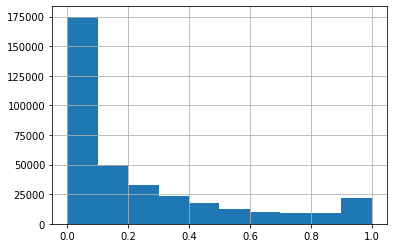

In [17]:
totals = has_qty_and_weights.groupby("url").agg(
    total_weight=("weight_in_grams", "sum"),
)

# len(has_qty_and_weights.dropna(subset="weight_in_grams")["ingredient_unit"])
# 359880.0 / 469190

# has_qty_and_weights.loc[has_qty_and_weights["quantity_float"].isnull()]

# has_qty_and_weights.loc[has_qty_and_weights["ingredient_name"] == "almonds"]["weight_in_grams"].hist(bins=20)

has_qty_and_weights
with_totals = has_qty_and_weights.join(
    totals,
    on="url",
    how="left",
)
with_totals

with_totals["weight_fraction"] = with_totals["weight_in_grams"] / with_totals["total_weight"]
# with_totals.loc[with_totals["ingredient_name"] == "butter"]["weight_fraction"].hist()
with_totals[["ingredient_name", "weight_fraction", "url", "total_weight"]]

with_totals.loc[with_totals["url"] == "http://allrecipes.com/Recipe/6664/"]

with_totals["weight_fraction"].hist()

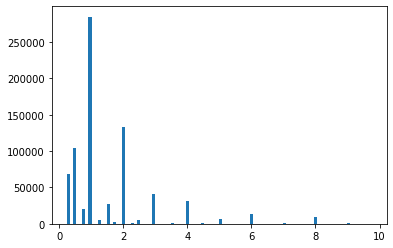

In [18]:
import pylab as pl
import numpy as np

pl.figure()
pl.hist(has_qty["quantity_float"].where(has_qty["quantity_float"] < 10), bins=100)
pl.show()

In [19]:
NUM_INGREDIENTS_FOR_GRAPH = 100

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(NUM_INGREDIENTS_FOR_GRAPH, columns=["ingredient_count"])

ingredient_count.reset_index(inplace=True)

common_ingredients = set(ingredient_count["ingredient_name"])

common_subset = df.loc[df["ingredient_name"].isin(common_ingredients)]


In [20]:
common_subset_2 = common_subset.copy()

merged = common_subset.merge(common_subset_2, on="url")
merged_without_same = merged.loc[merged["ingredient_name_x"] < merged["ingredient_name_y"]]

merged_without_same["edge"] = list(zip(
    merged_without_same["ingredient_name_x"],
    merged_without_same["ingredient_name_y"]))

weights = merged_without_same.groupby("edge").agg(
    edge_weight=("edge", "count"),
    urls=("url", set),
    edge=("edge", "first"),
    ingredient_x=("ingredient_name_x", "first"),
    ingredient_y=("ingredient_name_y", "first"),
)

# test = weights.sort_values('edge_weight', ascending = False).groupby("ingredient_x")['edge_weight'].head(3)

top_3_edges = weights.groupby("ingredient_x").apply(lambda grp: grp.nlargest(3, 'edge_weight'))["ingredient_y"]
weights = pd.merge(top_3_edges, weights, on=["ingredient_x", "ingredient_y"])

weights["edge_weight_normalized"] = weights["edge_weight"] / weights["edge_weight"].max()

weight_tuples = list(zip(
    weights["ingredient_x"],
    weights["ingredient_y"],
    weights["edge_weight_normalized"],
    weights["edge_weight"]))

best_per_ingredient = common_subset.where(
    common_subset['review_count'] > 50
).sort_values('rating_stars').drop_duplicates('ingredient_name',keep='last')


/tmp/ipykernel_9384/211676799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_without_same["edge"] = list(zip(


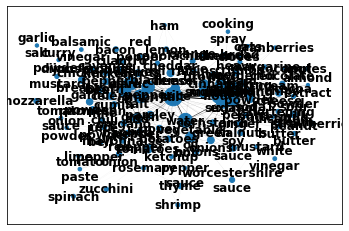

In [21]:
import networkx as nx

# plot the graph with networkx
G = nx.Graph()
G.add_nodes_from(common_ingredients)

[G.add_edge(u, v, weight=w) for u, v, w, _ in weight_tuples]

edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

pos = nx.spring_layout(G, iterations=50, seed=9)

node_size=[ingredient_count.loc[
    ingredient_count["ingredient_name"] == n
]["ingredient_count"] / 100 for n in G.nodes()]

nodenames = {n: n.replace(" ", "\n") for n in G.nodes()}

plt.grid(False)

nx.draw_networkx_nodes(G, pos, node_size=node_size)
nx.draw_networkx_labels(G, pos, labels=nodenames, font_weight="bold")
nx.draw_networkx_edges(G, pos, width=edgewidth,)

In [22]:
d3_format = {
    "nodes": [{"size": float(ingredient_count.loc[
                    ingredient_count["ingredient_name"] == n
                ]["ingredient_count"]),
                "id": n,
                "best_recipe": {
                    "title": str(best_per_ingredient.loc[
                        best_per_ingredient["ingredient_name"] == n
                    ]["title"].item()),
                    "url": str(best_per_ingredient.loc[
                        best_per_ingredient["ingredient_name"] == n
                    ]["url"].item())
                }
            } for n in common_ingredients],
    "links": [ {
        "source": u,
        "target": v,
        "value": d,
        "count": c
    } for (u,v,d,c) in weight_tuples]
}

with open("d3_graph.json", "w") as f:
    json.dump(d3_format, f)

<AxesSubplot:xlabel='quantity_tablespoons', ylabel='rating_stars'>

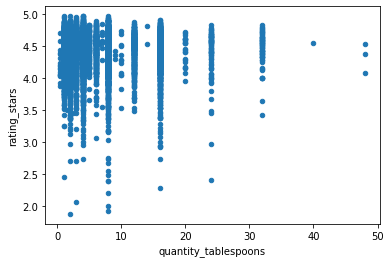

In [23]:
# analyze butter vs. rating
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

butter_recipes = df.loc[df["ingredient_name"].isin(["butter"])]

butter_recipes = butter_recipes[butter_recipes['ingredient_qty'].notnull()]


# only look at recipes with at least 10 reviews
butter_recipes = butter_recipes[butter_recipes['review_count'] >= 20]

butter_recipes["quantity_float"] = butter_recipes["ingredient_qty"].apply(convert_to_float)

butter_recipes = butter_recipes.loc[
    butter_recipes["ingredient_unit"
].isin(["cup", "tablespoon"])]

butter_recipes.loc[
    butter_recipes["ingredient_unit"] == "cup", 'quantity_tablespoons'
] = butter_recipes['quantity_float'] * 16

butter_recipes.loc[
    butter_recipes["ingredient_unit"] == "tablespoon", 'quantity_tablespoons'
] = butter_recipes['quantity_float']


# filter outliers
butter_recipes = butter_recipes[butter_recipes['quantity_tablespoons'] < 100]

# final = butter_recipes.groupby("quantity_tablespoons").agg(
#     avg_rating=("rating_stars", "mean"),
#     quantity_tablespoons=("quantity_tablespoons", "first")
# )
# print(final["quantity_tablespoons"].corr(final["avg_rating"]))

butter_recipes.plot.scatter(x="quantity_tablespoons", y="rating_stars")


10673


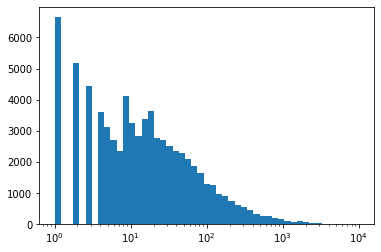

In [24]:
# analyze number of reviews distribution
import pylab as pl
import numpy as np

review_count_by_url = df.groupby(
    'url'
).agg(
    review_count=("review_count", "first")
)["review_count"]

print(review_count_by_url.max())

MIN, MAX = 1, 10000.0

pl.figure()
pl.hist(review_count_by_url, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
pl.gca().set_xscale("log")
pl.show()